In [1]:
from games.kuhn.kuhn3 import KuhnPoker3
from agents.counterfactualregret import CounterFactualRegret
from agents.agent_random import RandomAgent
from agents.mcts import MonteCarloTreeSearch
from agents.minimax import MiniMax
from collections import OrderedDict
import matplotlib.pyplot as plt
import numpy as np
from base.game import AlternatingGame, AgentID
from base.agent import Agent

In [2]:
def play(agents: dict[AgentID, tuple[str,Agent]], verbose = True, n=10):
    categories = ["Ganados"]
    results = {
        agent_id: [0] for agent_id in agents
    }
    rewards = { agent_id: [] for agent_id in agents }

    for i in range(n):
        # Se crea nueva instancia de juego para probar distintas posiciones
        game = KuhnPoker3()
        game.reset()
        if verbose:
            print(f"Initial Agent: {game.agent_selection} ({agents[game.agent_selection][0]})")
        while not game.game_over():
            game.render()
            agent_id = game.agent_selection
            agent_name, agent = agents[agent_id]

            # sobrescribo el juego dado que se crean nuevas instancias
            agent.game = game
            action = agent.action()
            if verbose:
                print(f"Agent {agent_id} ({agent_name}) plays action {action}")
            game.step(action=action)
        game.render()
        if game.truncated():
            if verbose:
                print("Game was truncated")
        for agent_id, (agent_name, _) in agents.items():
            if verbose:
                print(f"Reward agent {agent_id} ({agent_name}): {game.reward(agent_id)}")

        winner = max(game.rewards, key=game.rewards.get)

        if verbose:
            if winner is None:
                print(f"Drawn game")
            else:
                print(f"The winner is: {winner} ({agents[winner][0]})")

        for agent_id in agents:
            rewards[agent_id].append(game.reward(agent_id))
            if winner == agent_id:
                results[agent_id][0] += 1

    # Grafico rewards acumulados y cantidad de manos ganadas por cada agente
    _, axes = plt.subplots(nrows=1, ncols=2, figsize=(15,5))

    ax = axes[0]
    games = np.arange(1, n + 1)
    for agent_id, (agent_name, agent) in agents.items():
        ax.plot(games, np.cumsum(rewards[agent_id]), label=agent_name)
    ax.legend()
    ax.set_xlabel('Juegos')
    ax.set_ylabel('Rewards acumulados')

    ax = axes[1]
    x = np.arange(len(categories))
    bar_width = 0.35
    agent_ids = list(agents)

    ax.bar(x - bar_width, results[agent_ids[0]], bar_width, label=agents[agent_ids[0]][0])
    ax.bar(x, results[agent_ids[1]], bar_width, label=agents[agent_ids[1]][0])
    ax.bar(x + bar_width, results[agent_ids[2]], bar_width, label=agents[agent_ids[2]][0])

    ax.set_xticks(x)
    ax.set_xticklabels(categories)
    ax.set_ylabel('Cantidad')
    ax.set_title(f"Comparación de resultados sobre {n} juegos")
    ax.legend()

    plt.show()

In [3]:
g = KuhnPoker3()

In [4]:
cfr = CounterFactualRegret(game=g, agent=g.agents[1])
cfr.train(100000)
print(OrderedDict(map(lambda n: (n, cfr.node_dict[n].policy()), sorted(cfr.node_dict.keys()))))

OrderedDict([('0', array([0.99425937, 0.00574063])), ('0b', array([9.99960223e-01, 3.97772474e-05])), ('0bb', array([9.99959994e-01, 4.00064010e-05])), ('0bp', array([9.99959994e-01, 4.00064010e-05])), ('0p', array([0.93966456, 0.06033544])), ('0pb', array([9.99959994e-01, 4.00064010e-05])), ('0pbb', array([9.99969821e-01, 3.01786420e-05])), ('0pbp', array([9.99969821e-01, 3.01786420e-05])), ('0pp', array([0.95279598, 0.04720402])), ('0ppb', array([9.99949702e-01, 5.02977366e-05])), ('0ppbb', array([9.99936504e-01, 6.34956462e-05])), ('0ppbp', array([9.99915339e-01, 8.46608616e-05])), ('1', array([0.9948913, 0.0051087])), ('1b', array([9.99895523e-01, 1.04477204e-04])), ('1bb', array([9.99900343e-01, 9.96571793e-05])), ('1bp', array([9.99960137e-01, 3.98628717e-05])), ('1p', array([0.85907741, 0.14092259])), ('1pb', array([0.99459106, 0.00540894])), ('1pbb', array([9.99970165e-01, 2.98348123e-05])), ('1pbp', array([0.992257, 0.007743])), ('1pp', array([0.53609982, 0.46390018])), ('1ppb

### MCTS vs MinMax vs CFR

Initial Agent: agent_2 (MinMax)
agent_0 Q 
agent_1 A 
agent_2 J 
Agent agent_2 (MinMax) plays action 0
agent_0 Q p
agent_1 A p
agent_2 J p
Agent agent_0 (CFR) plays action 0
agent_0 Q pp
agent_1 A pp
agent_2 J pp
Agent agent_1 (MCTS) plays action 1
agent_0 Q ppb
agent_1 A ppb
agent_2 J ppb
Agent agent_2 (MinMax) plays action 0
agent_0 Q ppbp
agent_1 A ppbp
agent_2 J ppbp
Agent agent_0 (CFR) plays action 0
agent_0 Q ppbpp
agent_1 A ppbpp
agent_2 J ppbpp
Reward agent agent_0 (CFR): -1
Reward agent agent_1 (MCTS): 2
Reward agent agent_2 (MinMax): -1
The winner is: agent_1 (MCTS)
Initial Agent: agent_0 (CFR)
agent_0 J 
agent_1 K 
agent_2 Q 
Agent agent_0 (CFR) plays action 0
agent_0 J p
agent_1 K p
agent_2 Q p
Agent agent_1 (MCTS) plays action 1
agent_0 J pb
agent_1 K pb
agent_2 Q pb
Agent agent_2 (MinMax) plays action 0
agent_0 J pbp
agent_1 K pbp
agent_2 Q pbp
Agent agent_0 (CFR) plays action 0
agent_0 J pbpp
agent_1 K pbpp
agent_2 Q pbpp
Reward agent agent_0 (CFR): -1
Reward agent agent

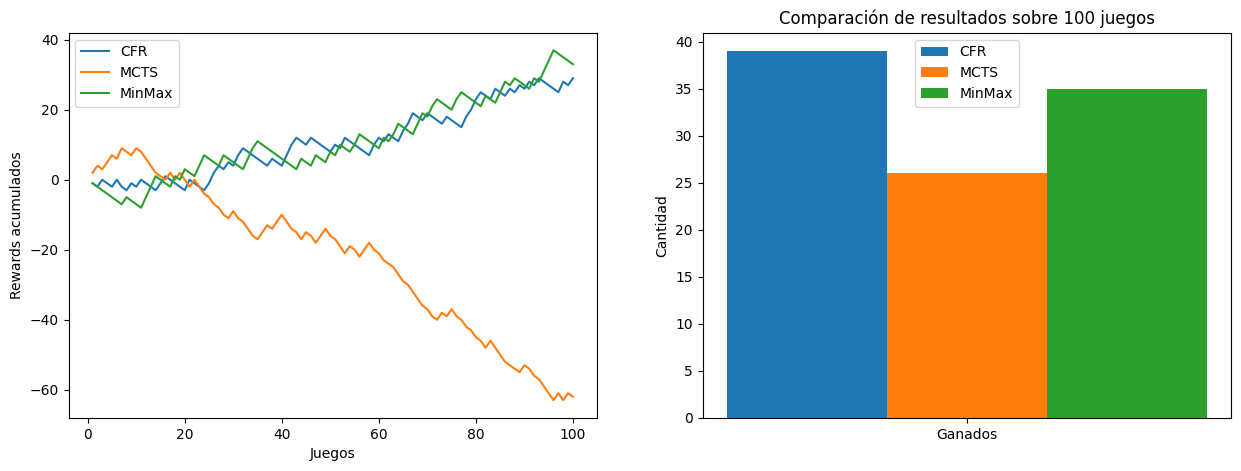

In [10]:
cfr.agent = g.agents[0]
play({
    g.agents[0]: ("CFR", cfr),
    g.agents[1]: ("MCTS", MonteCarloTreeSearch(game=g, agent=g.agents[1], max_depth=0, rollouts=50)),
    g.agents[2]: ("MinMax", MiniMax(game=g, agent=g.agents[2]))
}, n=100)

#### MCTS sims=300 vs MinMax vs MCTS sims=100

Initial Agent: agent_2 (MinMax)
agent_0 K 
agent_1 A 
agent_2 J 
Agent agent_2 (MinMax) plays action 0
agent_0 K p
agent_1 A p
agent_2 J p
Agent agent_0 (MCTS_300) plays action 1
agent_0 K pb
agent_1 A pb
agent_2 J pb
Agent agent_1 (MCTS_100) plays action 1
agent_0 K pbb
agent_1 A pbb
agent_2 J pbb
Agent agent_2 (MinMax) plays action 0
agent_0 K pbbp
agent_1 A pbbp
agent_2 J pbbp
Reward agent agent_0 (MCTS_300): -2
Reward agent agent_1 (MCTS_100): 3
Reward agent agent_2 (MinMax): -1
The winner is: agent_1 (MCTS_100)
Initial Agent: agent_0 (MCTS_300)
agent_0 Q 
agent_1 J 
agent_2 K 
Agent agent_0 (MCTS_300) plays action 1
agent_0 Q b
agent_1 J b
agent_2 K b
Agent agent_1 (MCTS_100) plays action 0
agent_0 Q bp
agent_1 J bp
agent_2 K bp
Agent agent_2 (MinMax) plays action 1
agent_0 Q bpb
agent_1 J bpb
agent_2 K bpb
Reward agent agent_0 (MCTS_300): -2
Reward agent agent_1 (MCTS_100): -1
Reward agent agent_2 (MinMax): 3
The winner is: agent_2 (MinMax)
Initial Agent: agent_1 (MCTS_100)
agent

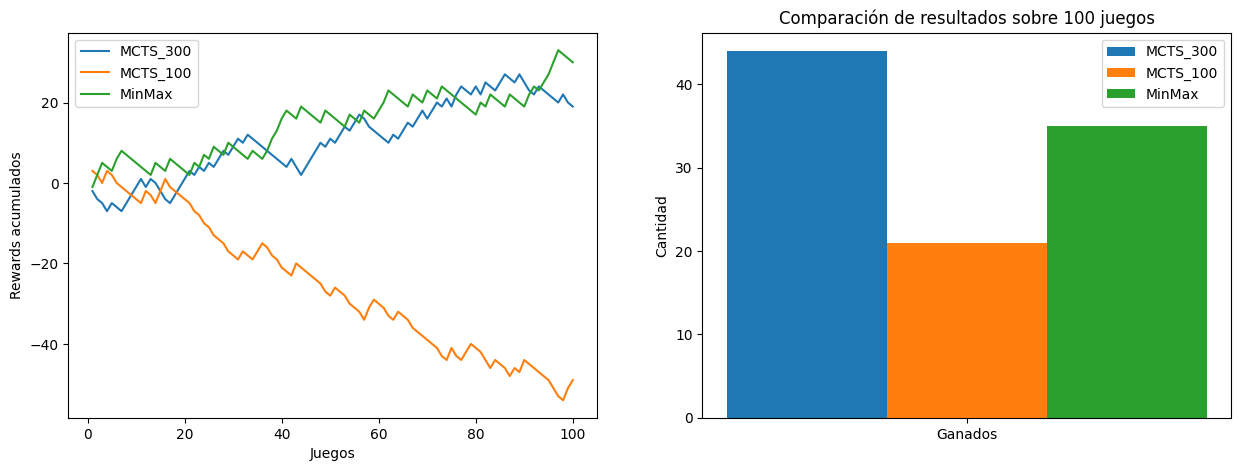

In [15]:
play({
    g.agents[0]: ("MCTS_300", MonteCarloTreeSearch(game=g, agent=g.agents[0], max_depth=0, simulations=300)),
    g.agents[1]: ("MCTS_100", MonteCarloTreeSearch(game=g, agent=g.agents[1], max_depth=0, simulations=100)),
    g.agents[2]: ("MinMax", MiniMax(game=g, agent=g.agents[2]))
}, n=100)

#### CFR vs CFR vs CFR

Initial Agent: agent_2 (CFR2)
agent_0 A 
agent_1 Q 
agent_2 K 
Agent agent_2 (CFR2) plays action 0
agent_0 A p
agent_1 Q p
agent_2 K p
Agent agent_0 (CFR0) plays action 0
agent_0 A pp
agent_1 Q pp
agent_2 K pp
Agent agent_1 (CFR1) plays action 0
agent_0 A ppp
agent_1 Q ppp
agent_2 K ppp
Reward agent agent_0 (CFR0): 2
Reward agent agent_1 (CFR1): -1
Reward agent agent_2 (CFR2): -1
The winner is: agent_0 (CFR0)
Initial Agent: agent_2 (CFR2)
agent_0 Q 
agent_1 K 
agent_2 J 
Agent agent_2 (CFR2) plays action 0
agent_0 Q p
agent_1 K p
agent_2 J p
Agent agent_0 (CFR0) plays action 0
agent_0 Q pp
agent_1 K pp
agent_2 J pp
Agent agent_1 (CFR1) plays action 0
agent_0 Q ppp
agent_1 K ppp
agent_2 J ppp
Reward agent agent_0 (CFR0): -1
Reward agent agent_1 (CFR1): 2
Reward agent agent_2 (CFR2): -1
The winner is: agent_1 (CFR1)
Initial Agent: agent_2 (CFR2)
agent_0 Q 
agent_1 A 
agent_2 K 
Agent agent_2 (CFR2) plays action 0
agent_0 Q p
agent_1 A p
agent_2 K p
Agent agent_0 (CFR0) plays action 0
age

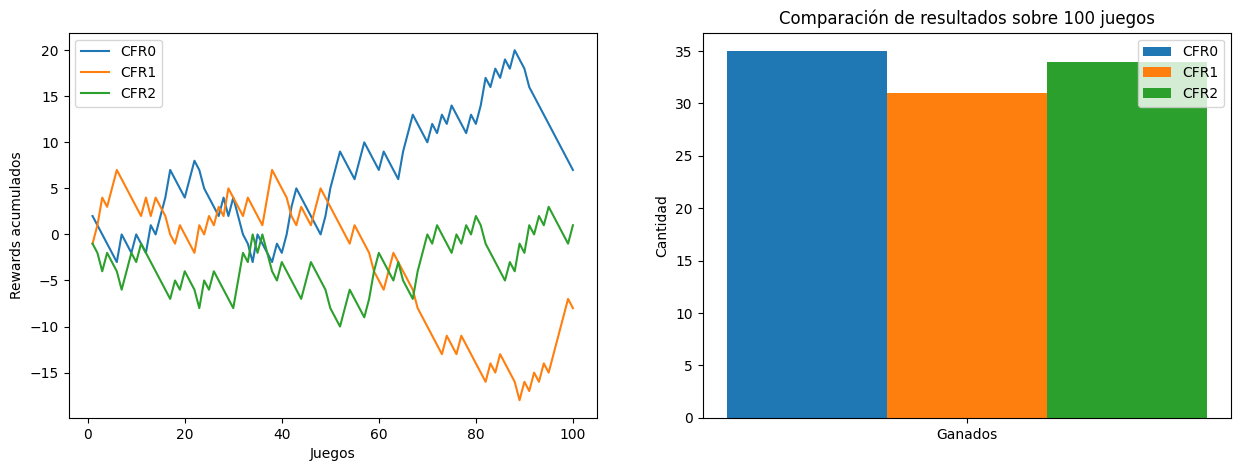

In [16]:
cfr0=CounterFactualRegret(game=g, agent=g.agents[0])
cfr0.node_dict = cfr.node_dict
cfr1=CounterFactualRegret(game=g, agent=g.agents[1])
cfr1.node_dict = cfr.node_dict
cfr2=CounterFactualRegret(game=g, agent=g.agents[2])
cfr2.node_dict = cfr.node_dict

play({
    g.agents[0]: ("CFR0", cfr0),
    g.agents[1]: ("CFR1", cfr1),
    g.agents[2]: ("CFR2", cfr2)
}, n=100)

#### Minimax vs Minimax vs Minimax

Initial Agent: agent_0 (Minimax0)
agent_0 K 
agent_1 J 
agent_2 Q 
Agent agent_0 (Minimax0) plays action 1
agent_0 K b
agent_1 J b
agent_2 Q b
Agent agent_1 (Minimax1) plays action 0
agent_0 K bp
agent_1 J bp
agent_2 Q bp
Agent agent_2 (Minimax2) plays action 0
agent_0 K bpp
agent_1 J bpp
agent_2 Q bpp
Reward agent agent_0 (Minimax0): 2
Reward agent agent_1 (Minimax1): -1
Reward agent agent_2 (Minimax2): -1
The winner is: agent_0 (Minimax0)
Initial Agent: agent_2 (Minimax2)
agent_0 K 
agent_1 Q 
agent_2 J 
Agent agent_2 (Minimax2) plays action 0
agent_0 K p
agent_1 Q p
agent_2 J p
Agent agent_0 (Minimax0) plays action 1
agent_0 K pb
agent_1 Q pb
agent_2 J pb
Agent agent_1 (Minimax1) plays action 0
agent_0 K pbp
agent_1 Q pbp
agent_2 J pbp
Agent agent_2 (Minimax2) plays action 0
agent_0 K pbpp
agent_1 Q pbpp
agent_2 J pbpp
Reward agent agent_0 (Minimax0): 2
Reward agent agent_1 (Minimax1): -1
Reward agent agent_2 (Minimax2): -1
The winner is: agent_0 (Minimax0)
Initial Agent: agent_0 (M

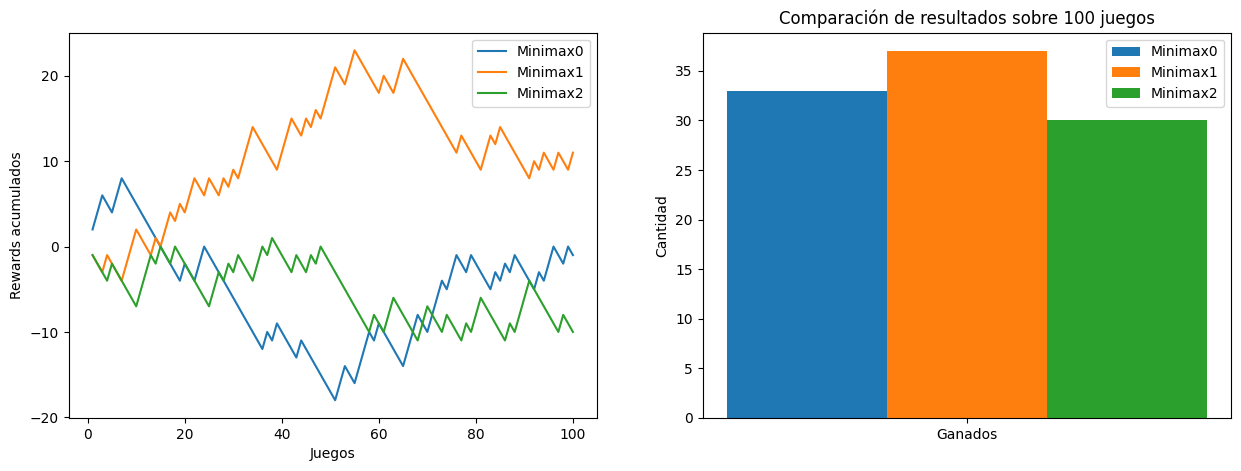

In [17]:
play({
    g.agents[0]: ("Minimax0", MiniMax(game=g, agent=g.agents[0])),
    g.agents[1]: ("Minimax1", MiniMax(game=g, agent=g.agents[1])),
    g.agents[2]: ("Minimax2", MiniMax(game=g, agent=g.agents[2]))
}, n=100)

#### CFR vs CFR vs Minimax

Initial Agent: agent_1 (CFR1)
agent_0 K 
agent_1 A 
agent_2 J 
Agent agent_1 (CFR1) plays action 0
agent_0 K p
agent_1 A p
agent_2 J p
Agent agent_2 (Minimax) plays action 0
agent_0 K pp
agent_1 A pp
agent_2 J pp
Agent agent_0 (CFR0) plays action 0
agent_0 K ppp
agent_1 A ppp
agent_2 J ppp
Reward agent agent_0 (CFR0): -1
Reward agent agent_1 (CFR1): 2
Reward agent agent_2 (Minimax): -1
The winner is: agent_1 (CFR1)
Initial Agent: agent_0 (CFR0)
agent_0 A 
agent_1 K 
agent_2 Q 
Agent agent_0 (CFR0) plays action 0
agent_0 A p
agent_1 K p
agent_2 Q p
Agent agent_1 (CFR1) plays action 0
agent_0 A pp
agent_1 K pp
agent_2 Q pp
Agent agent_2 (Minimax) plays action 0
agent_0 A ppp
agent_1 K ppp
agent_2 Q ppp
Reward agent agent_0 (CFR0): 2
Reward agent agent_1 (CFR1): -1
Reward agent agent_2 (Minimax): -1
The winner is: agent_0 (CFR0)
Initial Agent: agent_0 (CFR0)
agent_0 Q 
agent_1 K 
agent_2 A 
Agent agent_0 (CFR0) plays action 0
agent_0 Q p
agent_1 K p
agent_2 A p
Agent agent_1 (CFR1) plays 

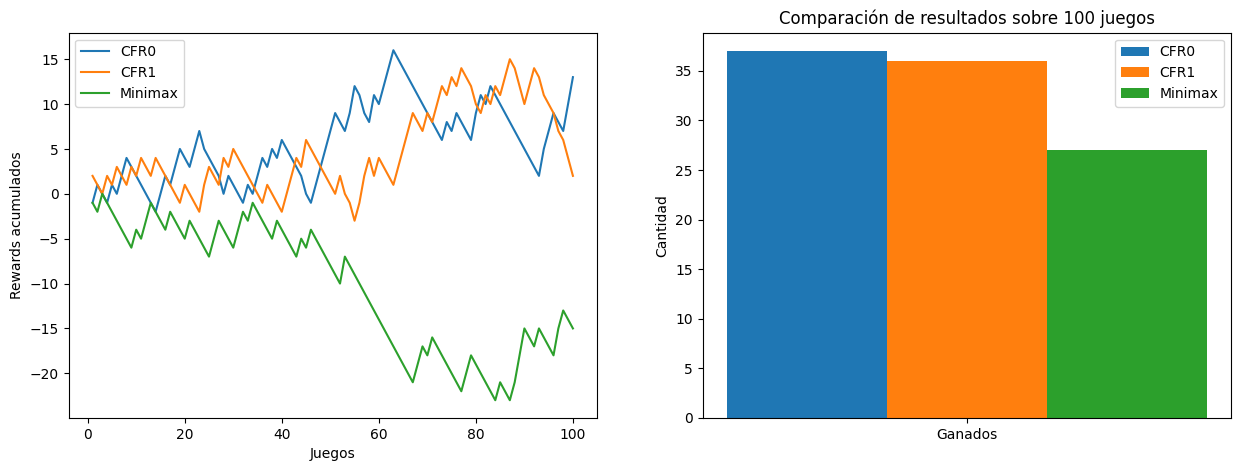

In [24]:
cfr0=CounterFactualRegret(game=g, agent=g.agents[0])
cfr0.node_dict = cfr.node_dict
cfr1=CounterFactualRegret(game=g, agent=g.agents[1])
cfr1.node_dict = cfr.node_dict

play({
    g.agents[0]: ("CFR0", cfr0),
    g.agents[1]: ("CFR1", cfr1),
    g.agents[2]: ("Minimax", MiniMax(game=g, agent=g.agents[2]))
}, n=100)